# Neural Network model development with Keras
Created by Ivan Lima on Mon Jun 13 2022 16:06:01 -0400

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os, datetime, warnings
print('Last updated on {}'.format(datetime.datetime.now().ctime()))

Last updated on Sun Nov 27 16:02:08 2022


In [2]:
import sns_settings
sns.set_context('paper')
pd.options.display.max_columns = 50
warnings.filterwarnings('ignore')

## Read merged bottle satellite data 

In [3]:
df = pd.read_csv('data/bottle_satellite_data_clean.csv', parse_dates=['Date'], index_col=0)

# add seasons
df.loc[df.Date.dt.month.isin([1,2,12]),'Season'] = 0  # Winter
df.loc[df.Date.dt.month.isin([3,4,5]),'Season'] = 1   # Spring
df.loc[df.Date.dt.month.isin([6,7,8]),'Season'] = 2   # Summer
df.loc[df.Date.dt.month.isin([9,10,11]),'Season'] = 3 # Fall 

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3623 entries, 0 to 3779
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   EXPOCODE       2488 non-null   object        
 1   Accession      1124 non-null   float64       
 2   Cruise_ID      3044 non-null   object        
 3   Date           3623 non-null   datetime64[ns]
 4   Year           3623 non-null   int64         
 5   Month          3623 non-null   int64         
 6   Day            3623 non-null   int64         
 7   Time_UTC       3543 non-null   object        
 8   Latitude       3623 non-null   float64       
 9   Longitude      3623 non-null   float64       
 10  Depth          3623 non-null   float64       
 11  Salinity       3623 non-null   float64       
 12  Temperature    3623 non-null   float64       
 13  Oxygen         3533 non-null   float64       
 14  DIC            3623 non-null   float64       
 15  DIC_FLAG       3329 n

In [4]:
# def find_outliers(df, vname):
#     cond = np.abs(df[vname] - df[vname].mean()) > 3 * df[vname].std()
#     df.loc[cond, vname] = np.nan

# for var in ['Temperature', 'Salinity', 'Oxygen', 'SLA', 'SST_hires', 'log_KD490']:
#     find_outliers(df, var)

## Select input features and split data into training and test sets 

In [5]:
from sklearn.model_selection import train_test_split, cross_val_score

# Set input and output variables
features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave', 'SLA', 'SST_hires', 'log_KD490']
# features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'pCO2_monthave', 'SLA', 'SST_hires', 'log_KD490']
# features = ['Depth', 'bottom_depth', 'Temperature', 'Salinity', 'pCO2_monthave']
# features = ['Depth', 'Temperature', 'Salinity', 'Oxygen', 'pCO2_monthave']
# features = ['Depth', 'Temperature', 'Salinity', 'pCO2_monthave']
targets  = ['DIC', 'TA']

data = df[features + targets + ['Season']].dropna()

X = data[features].values
Y = data[targets].values

# Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify=data.Season.values, random_state=42)

X.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((3533, 9), (2649, 9), (884, 9), (2649, 2), (884, 2))

In [6]:
# from sklearn.preprocessing import StandardScaler

# standardize/rescale data
# scaler = StandardScaler().fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_scaled = scaler.transform(X)

## Neural Network regression 

In [7]:
import tensorflow as tf
from tensorflow import keras

keras.utils.set_random_seed(42) # make things reproducible
n_hidden = 256 # number of nodes in hidden layers

# model = keras.models.Sequential([
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, activation='elu', input_shape=X_train.shape[1:]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, activation='elu'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(Y_train.shape[1])
# ])

# model = keras.models.Sequential([
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, activation='elu', kernel_initializer='he_normal', input_shape=X_train.shape[1:]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, activation='elu', kernel_initializer='he_normal'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(Y_train.shape[1])
# ])

# model = keras.models.Sequential([
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, activation='selu', kernel_initializer='lecun_normal', input_shape=X_train.shape[1:]),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, activation='selu', kernel_initializer='lecun_normal'),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(Y_train.shape[1])
# ])

## Monte Carlo dropout
# class MCDropout(keras.layers.Dropout):
#     def call(self, inputs):
#         return super().call(inputs, training=True)

# model = keras.models.Sequential([
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, input_shape=X_train.shape[1:]),
#     keras.layers.LeakyReLU(alpha=0.01),
#     keras.layers.BatchNormalization(),
#     MCDropout(rate=0.1),
#     keras.layers.Dense(n_hidden),
#     keras.layers.LeakyReLU(alpha=0.01),
#     keras.layers.BatchNormalization(),
#     MCDropout(rate=0.1),
#     keras.layers.Dense(Y_train.shape[1])
# ])

model = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, input_shape=X_train.shape[1:]),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(Y_train.shape[1])
])

# model = keras.models.Sequential([
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, kernel_initializer='he_normal', input_shape=X_train.shape[1:]),
#     keras.layers.LeakyReLU(alpha=0.01),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(n_hidden, kernel_initializer='he_normal'),
#     keras.layers.LeakyReLU(alpha=0.01),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(Y_train.shape[1])
# ])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
history = model.fit(X_train, Y_train, epochs=700, verbose=2, validation_split=0.2, callbacks=[early_stopping_cb])

2022-11-27 16:02:09.200641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-27 16:02:14.839541: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/700
67/67 - 2s - loss: 4679117.5000 - val_loss: 4446709.5000 - 2s/epoch - 31ms/step
Epoch 2/700
67/67 - 1s - loss: 4656455.0000 - val_loss: 4354419.0000 - 579ms/epoch - 9ms/step
Epoch 3/700
67/67 - 1s - loss: 4610863.0000 - val_loss: 4279181.5000 - 557ms/epoch - 8ms/step
Epoch 4/700
67/67 - 1s - loss: 4539676.0000 - val_loss: 4316134.5000 - 501ms/epoch - 7ms/step
Epoch 5/700
67/67 - 1s - loss: 4442847.5000 - val_loss: 4294603.5000 - 560ms/epoch - 8ms/step
Epoch 6/700
67/67 - 0s - loss: 4322218.5000 - val_loss: 4195834.0000 - 493ms/epoch - 7ms/step
Epoch 7/700
67/67 - 1s - loss: 4179994.0000 - val_loss: 4063415.0000 - 521ms/epoch - 8ms/step
Epoch 8/700
67/67 - 1s - loss: 4018689.0000 - val_loss: 3896553.5000 - 554ms/epoch - 8ms/step
Epoch 9/700
67/67 - 1s - loss: 3840935.2500 - val_loss: 3708948.2500 - 620ms/epoch - 9ms/step
Epoch 10/700
67/67 - 1s - loss: 3649408.2500 - val_loss: 3532103.0000 - 525ms/epoch - 8ms/step
Epoch 11/700
67/67 - 1s - loss: 3446702.2500 - val_loss: 3319

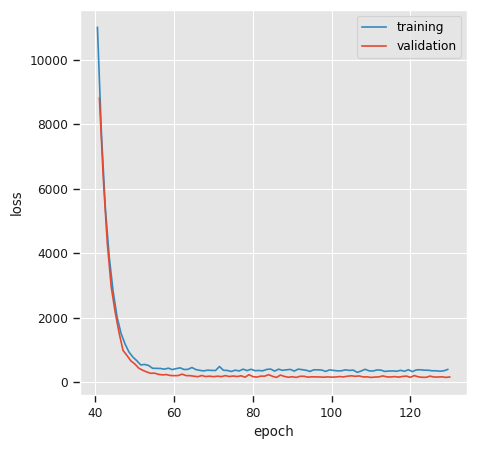

In [8]:
df_history = pd.DataFrame(history.history)
df_history.index = df_history.index + 1
df_history.index.name = 'epoch'

t = 40
fig, ax = plt.subplots()
_ = sns.lineplot(x=df_history[t:].index-0.5, y='loss', data=df_history[t:], ax=ax, label='training')
_ = sns.lineplot(x=df_history[t:].index, y='val_loss', data=df_history[t:], ax=ax, label='validation')
# _ = ax.set(yscale='log')

In [9]:
# from sklearn.metrics import r2_score

# # y_preds = np.stack([model(X_test, training=True) for s in range(500)])
# y_preds = np.stack([model(X_test) for s in range(500)])
# y_pred = y_preds.mean(axis=0)
# print('Test set R squared:         {:.3f}'.format(r2_score(Y_test, y_pred)))

MSE on training set

In [10]:
model.evaluate(X_train, Y_train)

83/83 [==============================] - 0s 4ms/step - loss: 139.0847


139.08465576171875

MSE on test set

In [11]:
model.evaluate(X_test, Y_test)

28/28 [==============================] - 0s 6ms/step - loss: 145.0471


145.04710388183594

In [12]:
from sklearn.metrics import r2_score

Y_pred_train = model.predict(X_train)
print('Training set R squared:         {:.3f}'.format(r2_score(Y_train, Y_pred_train)))
print('Training set R squared for DIC: {:.3f}'.format(r2_score(Y_train[:,0], Y_pred_train[:,0])))
print('Training set R squared for TA:  {:.3f}\n'.format(r2_score(Y_train[:,1], Y_pred_train[:,1])))

Y_pred_test = model.predict(X_test)
print('Test set R squared:         {:.3f}'.format(r2_score(Y_test, Y_pred_test)))
print('Test set R squared for DIC: {:.3f}'.format(r2_score(Y_test[:,0], Y_pred_test[:,0])))
print('Test set R squared for TA:  {:.3f}'.format(r2_score(Y_test[:,1], Y_pred_test[:,1])))

83/83 [==============================] - 1s 5ms/step
Training set R squared:         0.974
Training set R squared for DIC: 0.966
Training set R squared for TA:  0.983

28/28 [==============================] - 0s 4ms/step
Test set R squared:         0.973
Test set R squared for DIC: 0.963
Test set R squared for TA:  0.982


(1930.56260945, 2430.60939955, 1909.8516845703125, 2428.4656982421875)

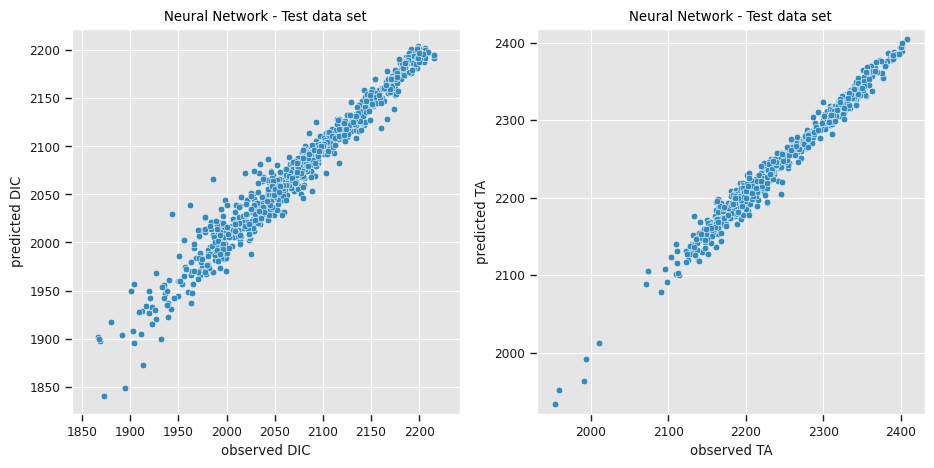

In [13]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(11, 5))
_ = sns.scatterplot(x=Y_test[:,0], y=Y_pred_test[:,0], ax=ax0)
_ = sns.scatterplot(x=Y_test[:,1], y=Y_pred_test[:,1], ax=ax1)
_ = ax0.set(xlabel='observed DIC', ylabel='predicted DIC', title='Neural Network - Test data set')
_ = ax1.set(xlabel='observed TA', ylabel='predicted TA', title='Neural Network - Test data set')
ax0.axis('equal')
ax1.axis('equal')

## Do k-fold cross-validation

In [14]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
score_vals = [] # store score values

nn_reg = keras.models.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden, input_shape=X_train.shape[1:]),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(n_hidden),
    keras.layers.LeakyReLU(alpha=0.01),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(Y_train.shape[1])
])
nn_reg.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())

for k, (train_idx, test_idx) in enumerate(kf.split(X_train)):
    X_tr, X_te = X_train[train_idx], X_train[test_idx]
    Y_tr, Y_te = Y_train[train_idx], Y_train[test_idx]
    history_cv = nn_reg.fit(X_tr, Y_tr, epochs=700, verbose=0, validation_split=0.2, callbacks=[early_stopping_cb])
    Y_pred = model.predict(X_te)
    score = r2_score(Y_te, Y_pred)
    score_vals.append(score)
    print('Fold {} test set R squared: {:.3f}'.format(k+1, score))

scores = np.array(score_vals)
print('\nBest R squared:  {:.3f}'.format(scores.max()))
print('Worst R squared: {:.3f}'.format(scores.min()))
print('Mean R squared:  {:.3f}'.format(scores.mean()))

17/17 [==============================] - 0s 5ms/step
Fold 1 test set R squared: 0.973
17/17 [==============================] - 0s 5ms/step
Fold 2 test set R squared: 0.974
17/17 [==============================] - 0s 6ms/step
Fold 3 test set R squared: 0.973
17/17 [==============================] - 0s 5ms/step
Fold 4 test set R squared: 0.978
17/17 [==============================] - 0s 5ms/step
Fold 5 test set R squared: 0.972

Best R squared:  0.978
Worst R squared: 0.972
Mean R squared:  0.974


In [15]:
# from sklearn.model_selection import cross_val_score

# def build_model(n_hidden=256, input_shape=X_train.shape[1:], alpha=0.01):
#     nn_model = keras.models.Sequential([
#         keras.layers.BatchNormalization(),
#         keras.layers.Dense(n_hidden, input_shape=input_shape),
#         keras.layers.LeakyReLU(alpha=alpha),
#         keras.layers.BatchNormalization(),
#         keras.layers.Dense(n_hidden),
#         keras.layers.LeakyReLU(alpha=alpha),
#         keras.layers.BatchNormalization(),
#         keras.layers.Dense(Y_train.shape[1])
#     ])
#     nn_model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam())
#     return nn_model

# # keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
# # keras_reg.fit(X_train, Y_train, epochs=300, verbose=2, validation_split=0.2, callbacks=[early_stopping_cb])

# keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_fn=build_model, epochs=300, verbose=0,
#                                                        validation_split=0.2, callbacks=[early_stopping_cb])
# # estimator= KerasRegressor(build_fn=buildmodel, epochs=100, batch_size=10, verbose=0)

# scores = cross_val_score(keras_reg, X_train, Y_train, n_jobs=-1)
# scores

## Results

Model $R^2$ scores on test set (using all variables):

Configuration     | Total |  DIC  | TA
------------------|-------|-------|------
LeakyReLU + BN    | 0.974 | 0.964 | 0.985
ELU + He + BN     | 0.972 | 0.961 | 0.983
ELU + BN          | 0.969 | 0.957 | 0.981
SELU + Lecun + BN | 0.968 | 0.957 | 0.980
ELU + He          | 0.956 | 0.937 | 0.976
LeakyReLU         | 0.950 | 0.930 | 0.970
SELU + Lecun      | 0.947 | 0.933 | 0.961
ELU               | 0.933 | 0.912 | 0.955

In [16]:
# def int2str(x):
#     return '{:02d}'.format(x)

# df['Month_str'] = df.Month.map(int2str)
# pd.get_dummies(df[['Month_str']])